# Setup, imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/honours
%ls

/content/drive/.shortcut-targets-by-id/19ffbnjWUM9FX-8Hcysq3IAN9wHHnO781/honours
all/                   hyperparameter_tuning.py  nonsaturated/      __pycache__/  sheets/
dried/                 model_creation.py         plot_functions.py  run_5fold.py
feature_extraction.py  model_plot.png            prep_functions.py  saturated/


In [ ]:
from prep_functions import create_images_list, extract_gh_values,extract_lp_values, circle_cut_out, scale_fit_transform
from plot_functions import plot_metrics,lin_regression,plot_predictions,plot_all_validation
from feature_extraction import get_distribution,get_image_contours,get_glcmprops,get_shape_features,get_lbp
from run_5fold import run_5fold,model_dict

In [ ]:
import pandas as pd
import numpy as np

# Data preparation

In [ ]:
#loading two datasets into respective dataframes
gh_df = pd.read_csv('/content/drive/MyDrive/honours/sheets/GrievesHouse.csv')
lp_df = pd.read_csv('/content/drive/MyDrive/honours/sheets/LowerPilmore.csv')

gh_df.head()

,Sample,Stable aggregates (%)
0,1,65.88
1,2,23.90
2,2,31.86
3,3,89.14
4,4,68.71


In [ ]:
# creating lists of images(scaled down) and respective label
gh_path = "/content/drive/MyDrive/honours/all/GrievesHouse/*.*"
lp_path = "/content/drive/MyDrive/honours/all/LowerPilmore/*.*"

gh_images,gh_labels = create_images_list(gh_path,(1024,1024),True)
lp_images,lp_labels = create_images_list(lp_path,(1024,1024),True)


In [ ]:
# CSV file naming differs from file naming - cleaning up:
gh_values = extract_gh_values(gh_labels,gh_df)
lp_values = extract_lp_values(lp_labels,lp_df)

all_values = gh_values + lp_values
all_values = np.array(all_values).reshape(-1, 1)

In [ ]:
from google.colab.patches import cv2_imshow

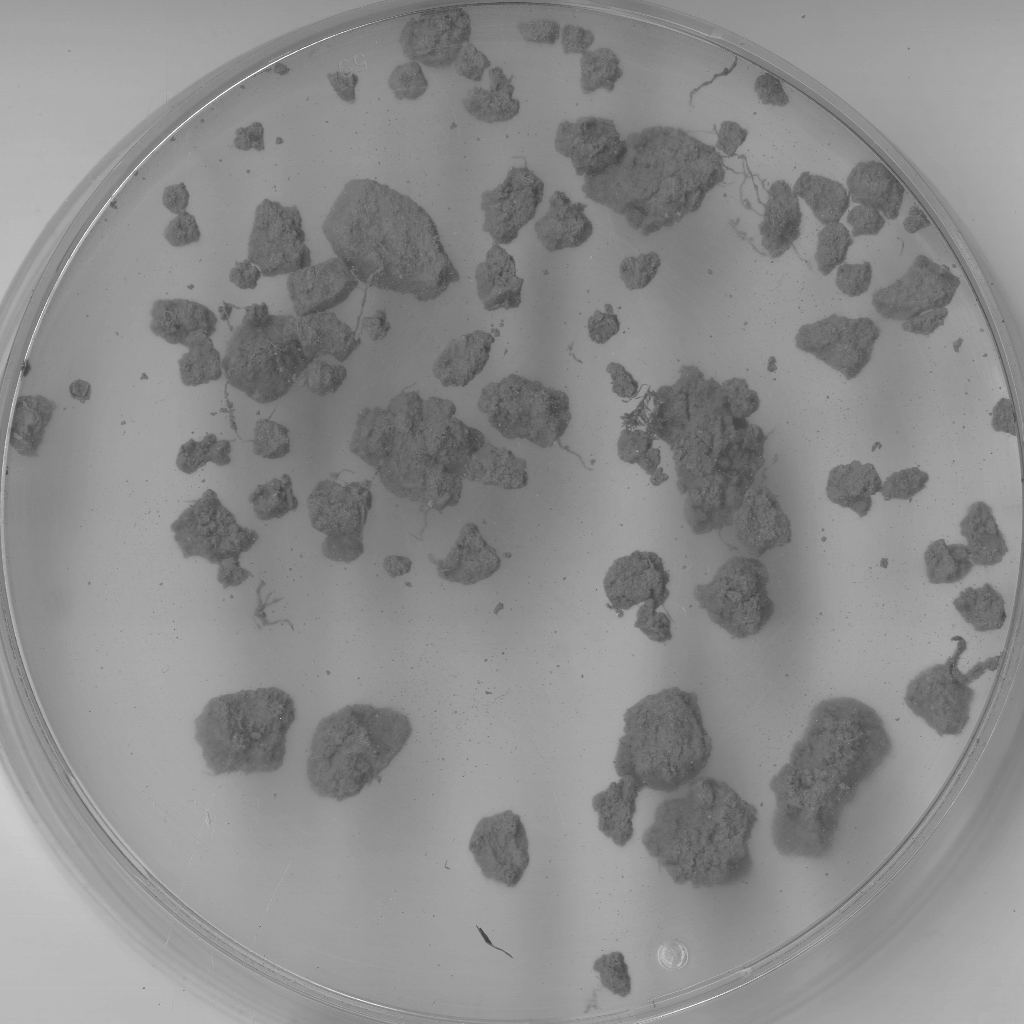

array([[157, 157, 157, ..., 157, 157, 157],
       [158, 157, 157, ..., 157, 157, 157],
       [158, 157, 157, ..., 157, 157, 157],
       ...,
       [184, 185, 184, ..., 179, 179, 179],
       [184, 185, 184, ..., 179, 179, 179],
       [184, 185, 185, ..., 179, 179, 179]], dtype=uint8)

In [ ]:
cv2_imshow(gh_images[1])
gh_images[1]

In [ ]:
gh_images[0].ndim

2

In [ ]:
all_images = gh_images + lp_images

feature_vectors = []

for curr_img in all_images:

  curr_contours,curr_perimeters,curr_areas = get_image_contours(curr_img)
  curr_aspects,curr_extents,curr_solidities,curr_diameters = get_shape_features(curr_contours)

  lbp_dist = get_lbp(curr_img,curr_contours)

  perimeter_dist = get_distribution(curr_perimeters,50)
  area_dist = get_distribution(curr_areas,50)
  aspect_dist = get_distribution(curr_aspects,50)
  extent_dist = get_distribution(curr_extents,50)
  solidity_dist = get_distribution(curr_solidities,50)

  vec = lbp_dist.tolist() + perimeter_dist.tolist() + area_dist.tolist() + aspect_dist.tolist() + extent_dist.tolist() + \
    solidity_dist.tolist()

  angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
  for i in range(1,6):
    for angle in angles:
      contrast,dissimiliarity,homogeneity,energy,correlation = get_glcmprops(curr_img,curr_contours,i,angle)

      vec += contrast.flatten().tolist() + dissimiliarity.flatten().tolist() + \
      homogeneity.flatten().tolist() + energy.flatten().tolist() + correlation.flatten().tolist()

  feature_vectors.append(vec)


In [ ]:
X = feature_vectors
y = all_values

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)

In [ ]:
splits = []
for i,(train_idx,test_idx) in enumerate(kf.split(X)):
  splits.append((train_idx,test_idx))

# XGBRegressor

## Best model


------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------


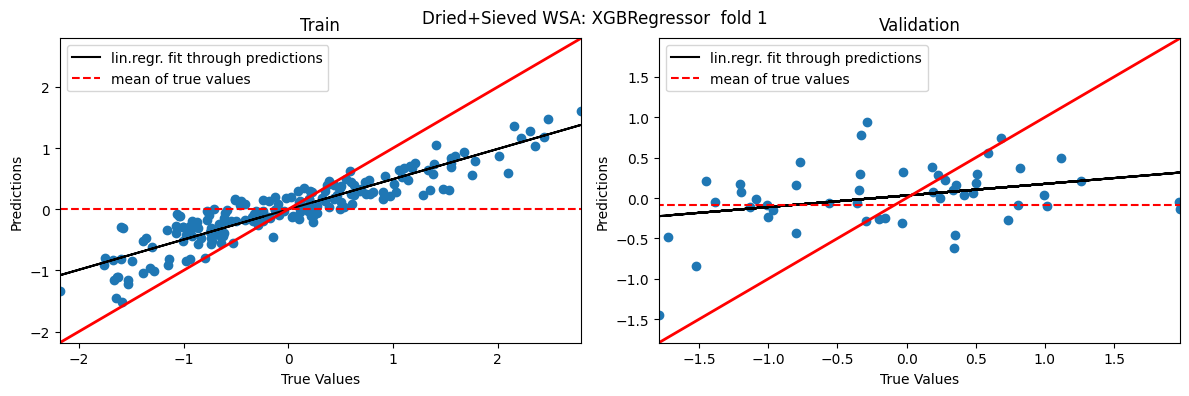

Train RMSE: 0.5502998630851267, MAE: 0.44169788662101844
Validation RMSE: 0.8644764482288018, MAE: 0.6906887667775571
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------


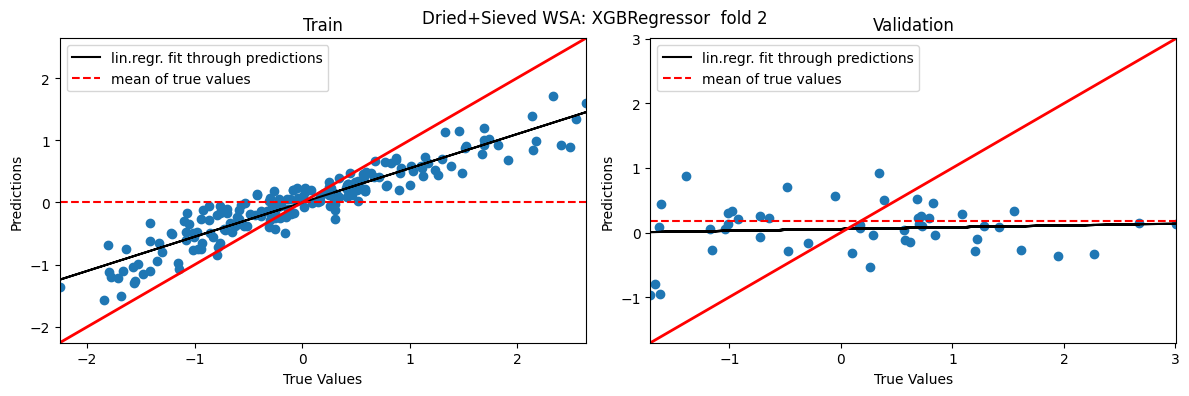

Train RMSE: 0.49521014792008555, MAE: 0.3910525620238906
Validation RMSE: 1.2013891199592341, MAE: 0.9822849696031465
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------


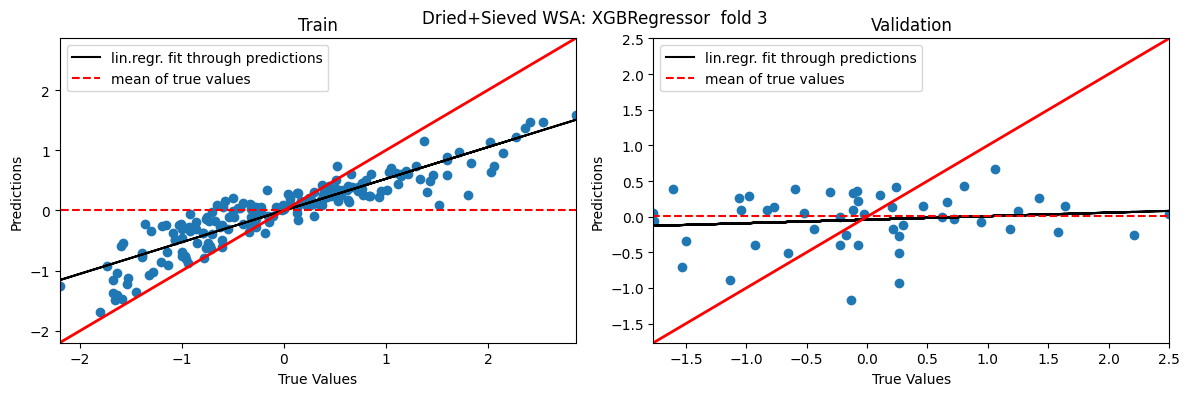

Train RMSE: 0.5283463041797497, MAE: 0.4123128907837689
Validation RMSE: 1.0080681084239473, MAE: 0.8013148526178191
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------


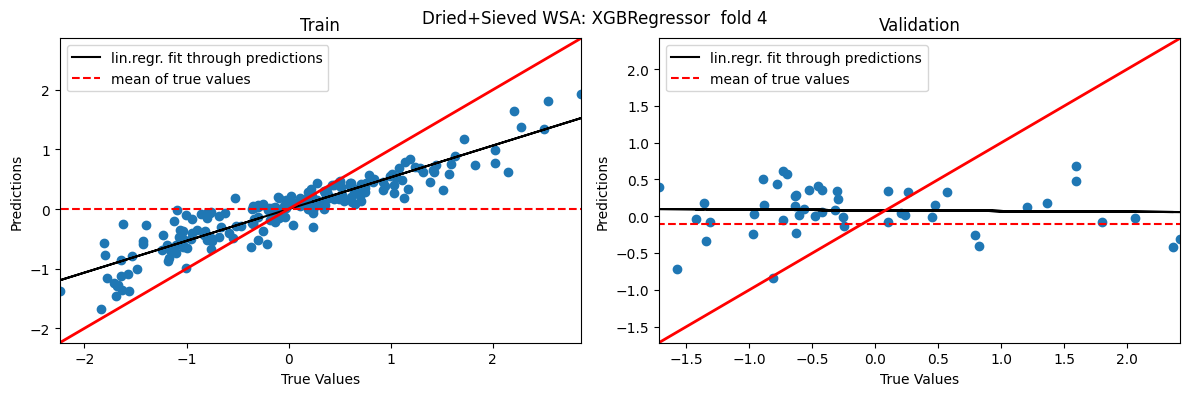

Train RMSE: 0.5176773312695138, MAE: 0.4117341747133954
Validation RMSE: 1.1027076984069462, MAE: 0.9076673813776722
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------


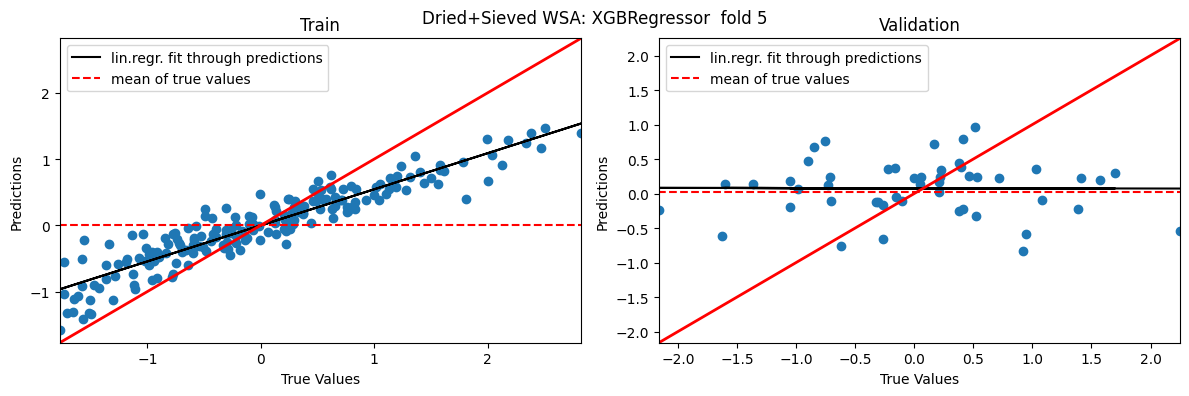

Train RMSE: 0.5033895231343771, MAE: 0.3976650929722852
Validation RMSE: 0.9928578920259129, MAE: 0.761001361702033


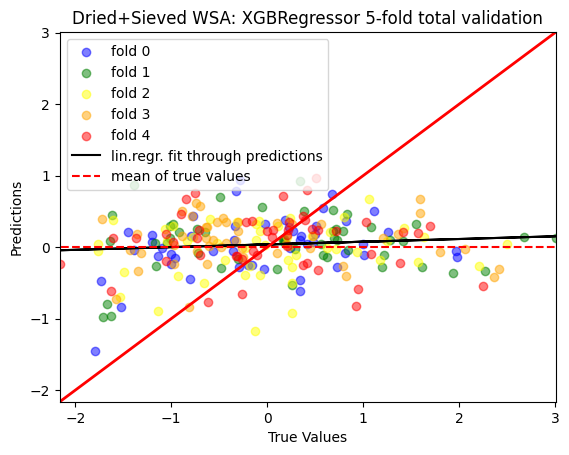

Total validation RMSE: 1.0401094882360449
Total validation MAE: 0.8286553967943882


In [ ]:
run_5fold('XGBRegressor','Dried+Sieved','WSA', model_dict,splits,X,y,False,None)

#RandomForestRegressor

## Best model

------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------


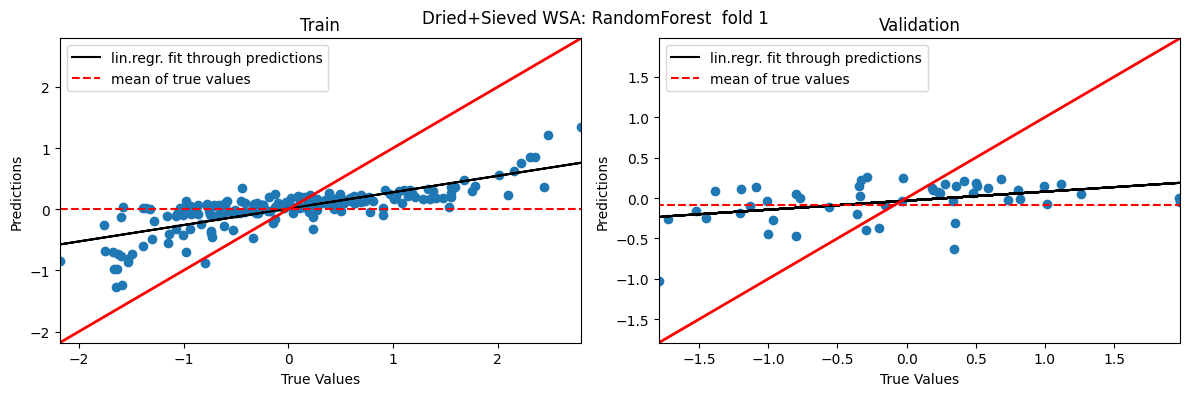

Train RMSE: 0.7635969034924083, MAE: 0.627174185292874
Validation RMSE: 0.8305902354410333, MAE: 0.671801706425775
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------


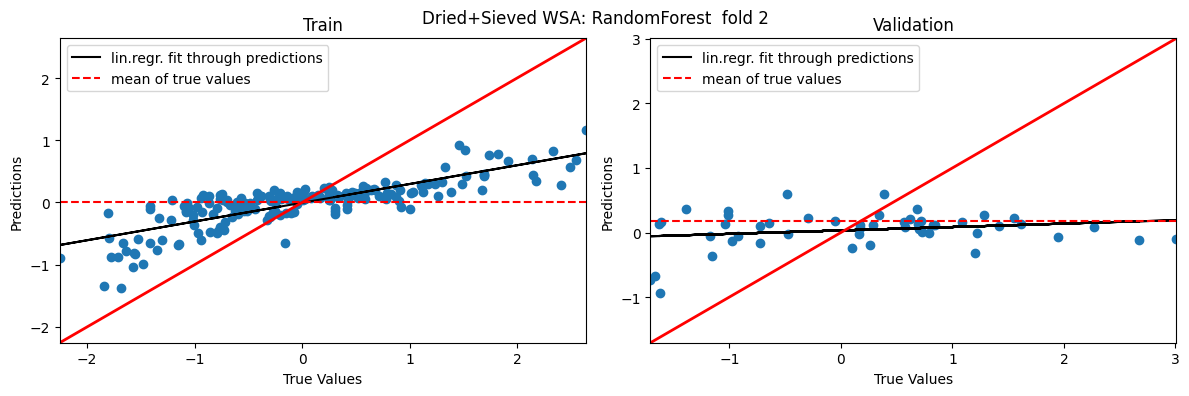

Train RMSE: 0.7311707989535116, MAE: 0.5938668663349134
Validation RMSE: 1.14376477026814, MAE: 0.9339734257121012
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------


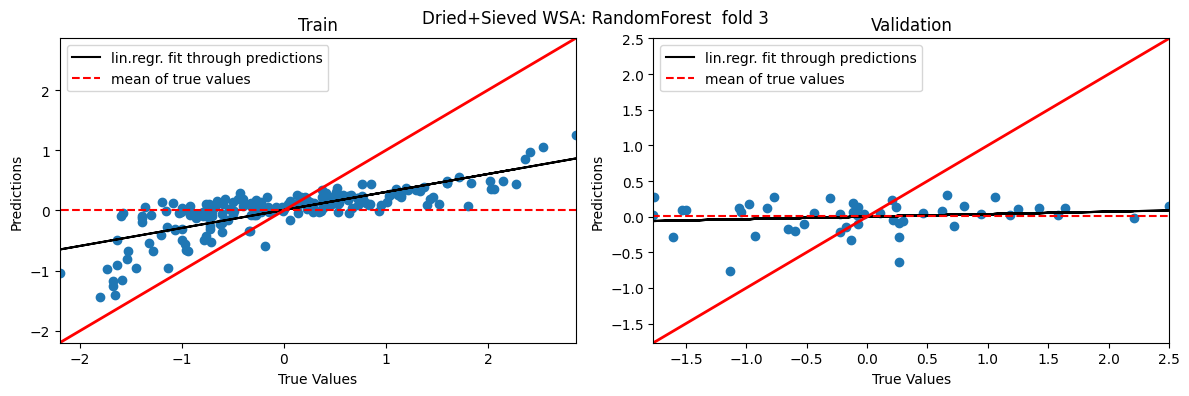

Train RMSE: 0.7420483501847411, MAE: 0.6034441396398096
Validation RMSE: 0.9728606083953523, MAE: 0.7540091406886331
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------


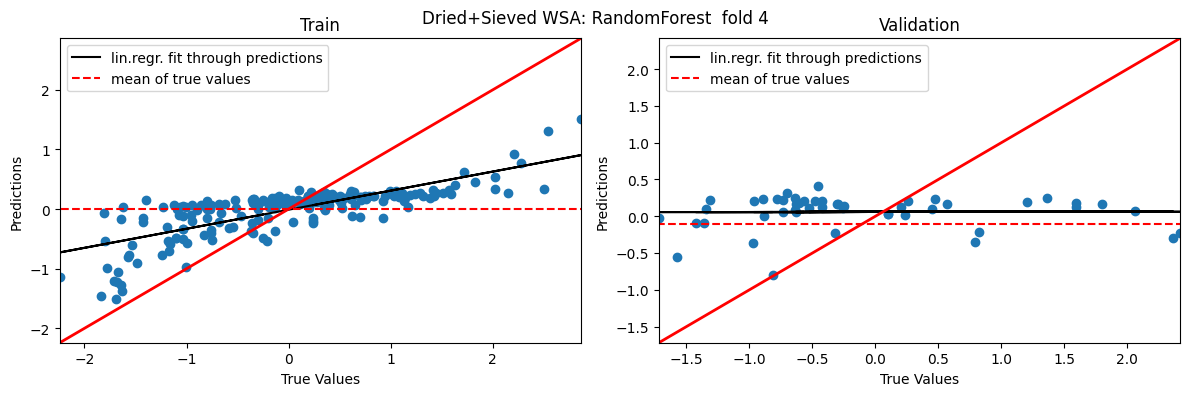

Train RMSE: 0.7307730047833013, MAE: 0.586073873819181
Validation RMSE: 1.06557130346265, MAE: 0.8826469160965292
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------


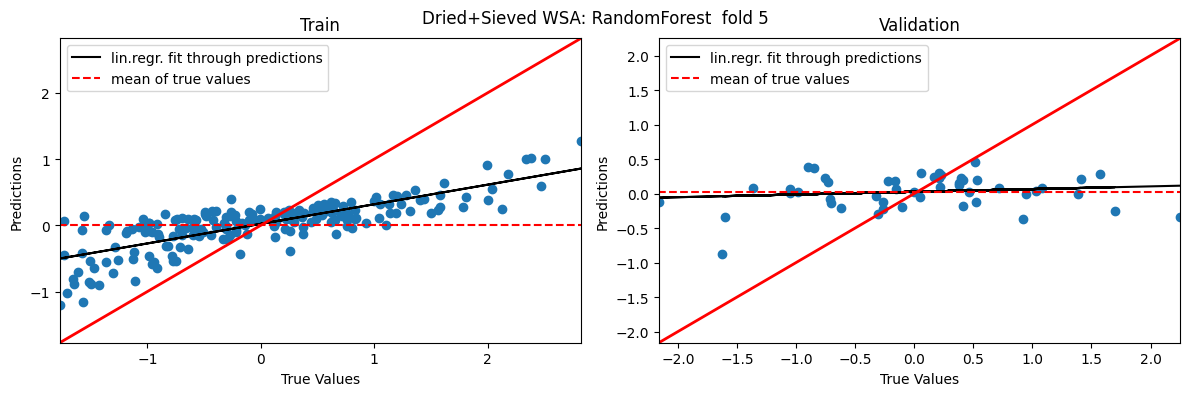

Train RMSE: 0.7398440709667223, MAE: 0.6063153698725835
Validation RMSE: 0.9023153055929638, MAE: 0.6752270870189684


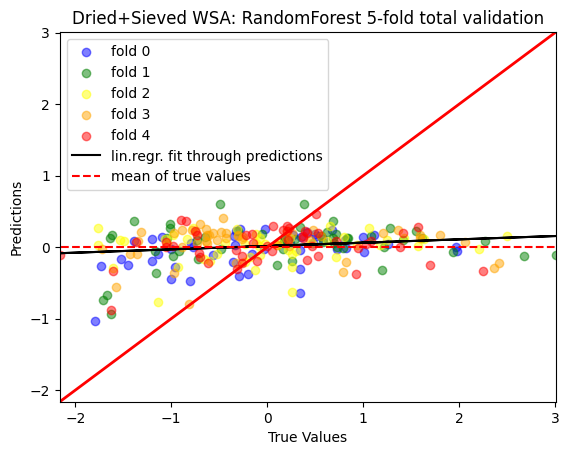

Total validation RMSE: 0.989441159105224
Total validation MAE: 0.7836883832117255


In [ ]:
run_5fold('RandomForest','Dried+Sieved','WSA', model_dict,splits,X,y,False,None)

In [ ]:
print(len(X[0]))

368


In [ ]:
lbp_dist = get_lbp(curr_img,curr_contours)
len(lbp_dist)

18